# Neural Networks for Data Science Applications
## Homework 1: Customized activation functions

**Name**: Lorenzo Pannacci

**Matricola**: 1948926

> ✍ Upload the completed notebook **before 13/11/2024 at 23:59** on the Google Classroom page.

### Instructions

1. The homework is divided into four mandatory exercises (**5 points in total**) and 1 optional exercise. The optional one is ungraded but I may take it into consideration for the final mark during the oral.
2. Completing the homework successfully will remove 1 exercise from the end-of-term homework.
3. Marks between 4 and 5 can be fully recovered during the oral examination.
3. If you want to improve the mark, you are also free to complete the full EoT homework to recover a full mark.
3. The grade can be kept for the entire academic year (up to October 2025).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and JAX*: the homework must be done _fully in JAX_ (except where specified) while vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

### Introduction: Trainable activation functions

Remember that a trainable variant of the Swish function can be written as:

$$ \phi(s) = (as + b)\sigma(cs + d) $$

where $s$ is the scalar input of the AF, $\left\{a, b, c, d\right\}$ are four scalar parameters, and $\sigma$ is the sigmoid function. Note how this can be (roughly) interpreted as a one-hidden layer MLP with one input, one hidden unit, and one output. Thus, we can easily generalize this as:

$$ \phi(s) = \sum_{i=1}^n (a_is+b_i)\sigma(c_is+d_i) \tag{1} $$

where $n$ is an hyper-parameter, and the function has now $4n$ parameters $\left\{a_i, b_i, c_i, d_i\right\}_{i=1}^n$. By varying $n$ we can make the activation function as complicated as we want: we say this is a **non-parametric** AF [1]. The homework will guide you to implement an MLP exploiting (1) in JAX.

In [ ]:
import jax
import jax.numpy as jnp

# install and import the rest of the required libraries

!pip install jaxtyping ucimlrepo --quiet

from typing import Tuple
from jaxtyping import Array, Float, Int, Bool
from functools import partial

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from tqdm.notebook import tqdm

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 704.4 kB/s eta 0:00:00


### Exercise 1 (1 point)

We begin by implementing (1) (no MLPs for now) in JAX. Following what we saw in the first lab session, implement equation (1) in pure JAX (no external libraries) using a pair of (init, call) functions, respectively for initializing the parameters and for computing the outputs of the AF.

For the purpose of this exercise we consider a single AF with mini-batching over the input, hence the signature of the functions should be:

```
def init_fcn(key, n):
   # key is the PNRG state
   # n is the hyper-parameter in (1)
   # Returns: the parameters (a,b,c,d) in whatever format you prefer.
```


```
def call_fcn(params, x: Float[Array, "b"])
           -> Float[Array, "b"]:
   # x is a vector (mini-batch) of b inputs to the function
   # params is the output of init_fcn
   # Returns the corresponding outputs ϕ(x1), ϕ(x2), ..., ϕ(xb).
```






✅ **Completion requirement**: Show me the two functions work as expected. For example, you can plot some randomly-initialized functions for different choices of $n$.

In [ ]:
##############################
# TODO: implement Exercise 1 #
##############################

def init_fcn(key: Int, n: Int = 10, mean: Float = 0, stdev: Float = 1):
    '''
    Function signature:
    key: PNRG state
    n: hyper-parameter in (1)
    returns: the parameters (a,b,c,d)

    We save the parameters as a matrix of dimension n x 4;
    The columns of the matrix are the parameters a, b, c, d in this order.

    For the initialization we choose random values from a normal
    distribution for the coefficients and zeros for the biases.
    '''

    # split the random key
    key, subkey = jax.random.split(key)

    # generate the random matrix

    # initialization is with a normal distribution for a and c
    # and zeros for b and d
    params = jax.random.normal(subkey, shape=(n, 4)) * stdev + mean
    params.at[..., 1:2].set(0)
    params.at[..., 3:4].set(0)

    return params, key

@jax.jit
def call_fcn(params, x: Float[Array, "b"]) -> Float[Array, "b"]:
    '''
    Function signature:
    x: vector (mini-batch) of b inputs to the function
    params: the output of init_fcn
    returns: the corresponding outputs ϕ(x1), ϕ(x2), ..., ϕ(xb).

    The function implements the formula (1) in a vectorized way for the
    mini-batches.
    '''

    # extract parameters vectors a, b, c, d from the parameters matrix
    a = params[..., 0:1]
    b = params[..., 1:2]
    c = params[..., 2:3]
    d = params[..., 3:4]

    # compute the "(as + b)" part of all the n activation functions
    # for all the given inputs
    linear_components = jnp.dot(a, x[:, None].T) + b
    # size is (n, batch_size)

    # compute the "σ(cs + d)" part of all the n activation functions
    # for all the given inputs
    sigmoid_components = jax.nn.sigmoid(jnp.dot(c, x[:, None].T) + d)
    # size is (n, batch_size)

    # element-wise multiply the two parts to get each "generalized swish"
    all_swishes = jnp.multiply(linear_components, sigmoid_components)
    # size is (n, batch_size)

    # sum over the first dimension to get the final activation function
    # output for all the given inputs
    all_outputs = jnp.sum(all_swishes, axis=0)
    # size is (, batch_size)

    return all_outputs

To show that the functions work as expected I have decided to implement two examples:

*   As suggested by the homework I plotted five different activation functions obtained from the sums of different amounts of "generalized swishes" varying $n$.
*   Moreover, as an ulterior check to see if the parameter matrix works as intended I also plotted two "canonical" activation functions: the *sigmoid* and the *1-swish*. I compared my implementation with what is implemented inside JAX.

To get the canonical activation function I setted up $n=1$ and:
*  For the sigmoid: $\,\, σ(s) = (0 \cdot s + 1)σ(1 \cdot s + 0) \Rightarrow a = 0, b = 1, c = 1, d = 0$
*  For the 1-swish: $sσ(s) = (1 \cdot s + 0)σ(1 \cdot s + 0) \Rightarrow a = 1, b = 0, c = 1, d = 0$


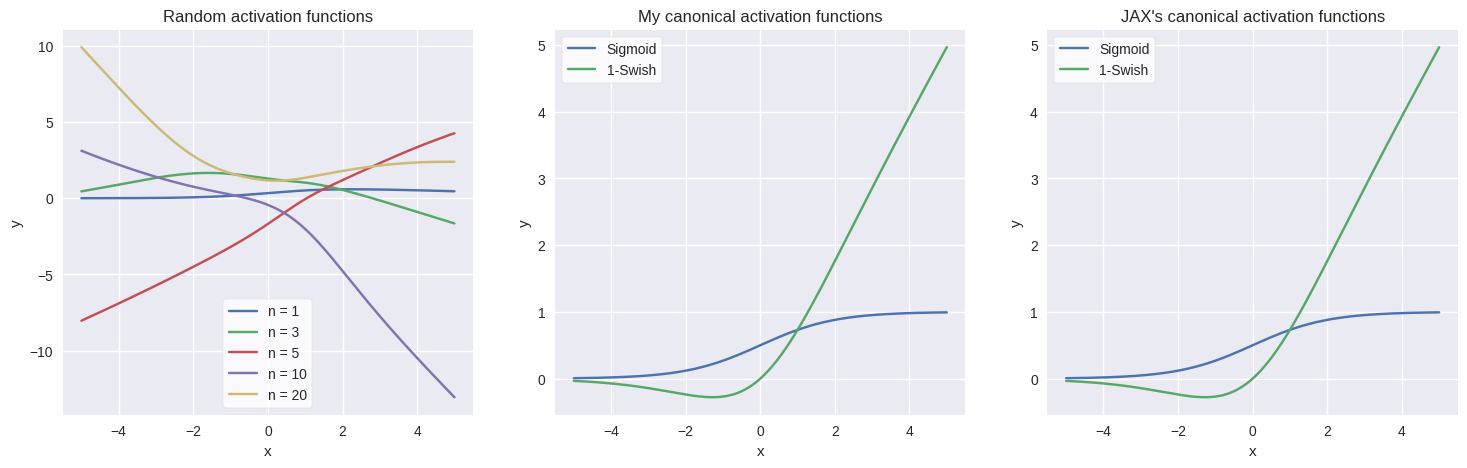

In [ ]:
#############################################
# Examples to show that the algorithm works #
#############################################

plt.style.use('seaborn-v0_8')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
x = jnp.linspace(-5, 5, 1000)

# plot five random activation functions with different n values

n_list = [1, 3, 5, 10, 20]
key = jax.random.PRNGKey(0)

for n in n_list:
    # get random key for initialization
    key, subkey = jax.random.split(key)

    # initialize parameters
    params, key = init_fcn(key, n)

    # get the y of the function for plotting
    y = call_fcn(params, x)

    # plot the activation fuction curve
    ax1.plot(x, y, label=f'n = {n}')

# setup the rest of the plot
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Random activation functions")
ax1.legend(frameon=True, facecolor="white")

# my sigmoid activation function

params = jnp.array([[0, 1, 1, 0]], dtype=float)
y = call_fcn(params, x)
ax2.plot(x, y, label=f'Sigmoid')

# my 1-swish activation function

params = jnp.array([[1, 0, 1, 0]], dtype=float)
y = call_fcn(params, x)
ax2.plot(x, y, label=f'1-Swish')

# setup the rest of the plot
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("My canonical activation functions")
ax2.legend(frameon=True, facecolor="white")

# JAX's sigmoid activation function

y = jax.nn.sigmoid(x)
ax3.plot(x, y, label=f'Sigmoid')

# JAX's 1-swish activation function

y = jax.nn.swish(x)
ax3.plot(x, y, label=f'1-Swish')

# setup the rest of the plot
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("JAX's canonical activation functions")
ax3.legend(frameon=True, facecolor="white");

### Exercise 2 (1 point)

One issue of non-parametric AF is that they tend to work poorly when randomly-initialized. However, it is relatively easy to fix the parameters of (1) so that the initialized functions approximate any scalar function we desire (in fact, (1) for $n \rightarrow \infty$ is a universal approximator for 1D functions).

For this exercise, write a gradient descent procedure (again, pure JAX) that given $n$ finds the optimal coefficients $\left\{a_i, b_i, c_i, d_i\right\}$ such that:

$$ \phi(s) \approx \text{ReLU}(s) $$

Note that all functions from Exercise 1 and 2 should be scalar-valued apart from mini-batching.

✅ **Completion requirement**: Show me gradient descent converges correctly. For example, you can plot the quality of the approximation when increasing $n$.

In [ ]:
#############################
# TODO: complete Exercise 2 #
#############################

@jax.jit
def real_relu(x: Float[Array, "b"]) -> Float[Array, "b"]:
    '''
    This function is the real ReLU activation function. I use it to
    generate the training data.
    '''

    return jnp.maximum(0, x)

@jax.jit
@jax.value_and_grad
def mean_squared_error(params, x: Float[Array, "b"]):
    '''
    We will use as loss function for the gradient descent the mean
    squared error.
    '''

    # get ground truth
    y = real_relu(x)

    # get model approximation
    yhat = call_fcn(params, x)

    # calculate mean squared error
    mse = jnp.mean((y - yhat) ** 2)

    return mse

def gradient_descent(n: Int, n_iterations: Int, learning_rate: Float,\
                     key: Int, history: Bool = False, mean: Float = 0,\
                     stdev: Float = 1):
    '''
    Implementation of the gradient descent loop for the training of the
    generalized activation function to imitate a ReLU.
    '''

    # initialize activation function
    params, key = init_fcn(key, n, mean, stdev)

    # input values
    x = jnp.linspace(-10, 10, 1000)

    loss_history = []
    for _ in range(n_iterations):
        # get loss and gradients
        loss_value, grads = mean_squared_error(params, x)

        if history:
            # append new loss
            loss_history.append(loss_value)

        # update parameters with gradient descent
        params -= learning_rate * grads

    if history:
        return params, loss_history, key

    else:
        return params, key

Similarly to before I show the results varying $n$: I plot both the loss history of the gradient descents and the final activation function curves together with the real ReLU.

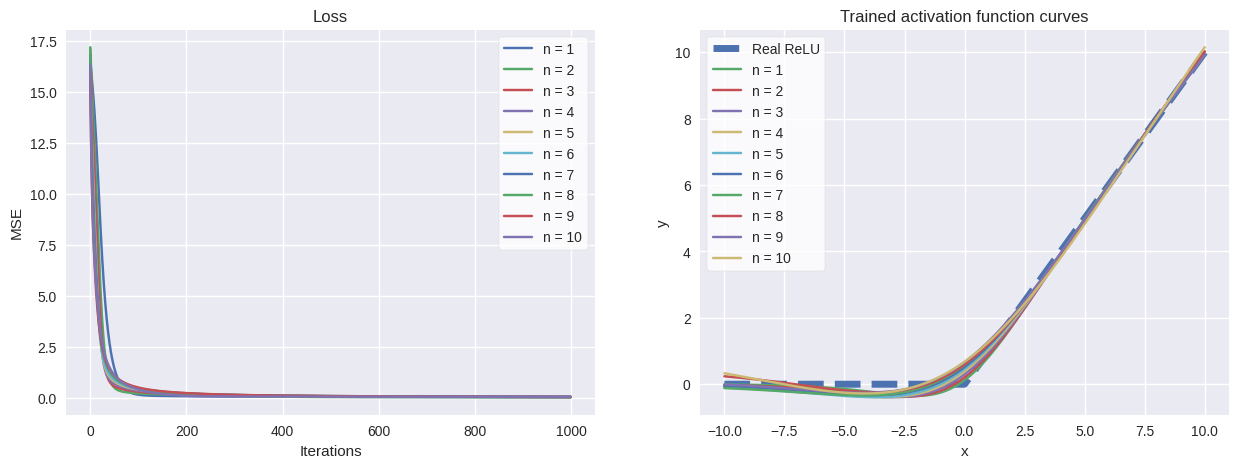

In [ ]:
#############################################
# Examples to show that the algorithm works #
#############################################

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
key = jax.random.PRNGKey(0)

# use integers from 1 to 10 as values from n
n_list = list(range(1, 11))

# add to curve plot for the real ReLU
x = jnp.linspace(-10, 10, 1000)
y = jax.nn.relu(x)
ax2.plot(x, y, '--', label=f'Real ReLU', linewidth=5.0)

# initialize gradient descent training parameters
n_iterations = 1000
learning_rate = 0.001

for n in n_list:
    # initialize and train activation function
    params, loss, key = gradient_descent(n,
                                         n_iterations,
                                         learning_rate,
                                         key,
                                         history=True,
                                         stdev=0.01)

    # get activation function curve
    y = call_fcn(params, x)

    # add loss and curve to the plots
    ax1.plot(loss, label=f'n = {n}')
    ax2.plot(x, y, label=f'n = {n}')

# setup the rest of the plot
ax1.set_title('Loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')
ax1.legend(frameon=True, facecolor="white")

ax2.set_title('Trained activation function curves')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.legend(frameon=True, facecolor="white");

### Exercise 3 (1 point)

Clearly, a single activation function is not enough. For example, consider the following Sequential model in Keras:

```
model = Sequential([
  Dense(5),
  ReLU(),
  Dense(1)  
])
```
We would like to replace the intermediate ReLU layer with an equivalent layer implementing (1), where each unit (neuron) in the layer is assigned a different AF. Luckily, we can use `jax.vmap` over the result of Exercise 1 to solve this.

For this exercise, apply `vmap` over `call_fcn` to obtain the following variants:

1.   A single AF (shared parameters) for all the units of the layer.
2.   Different AFs (different parameters) for each unit in the layer.
3. (**Optional, more difficult**) A KAN-style AF [2] where a different AF is applied to each edge of a fully-connected layer.

The signature of all vmapped functions should be:

```
def vmapped_call_fcn(params, x: Float[Array, "b h"])
           -> Float[Array, "b h"]:
   ...
```
where $x$ is a generic output of a fully-connected layer, so that $h$ is the number of hidden units in the layer (e.g., $h=5$ for the first `Dense` layer above). For the new initialization functions, you are free to either rewrite them or find some way to vectorize the original one.

✅ **Completion requirement**: Show me the vectorization works as expected (e.g., generate and visualize multiple functions simultaneously).

---

In the first variant we have a single activation function for all the units, in the second variant we have a different activation function for each output unit, which can be seen as a vector of activation functions of length $h$. For the third variant we want a unique activation function for each couple input-output, therefore we have to add yet another dimension, obtaining a matrix of activation functions of shape $(h_1 × h_2)$, where $h_1$ is the amount of input units and $h_2$ the amount of output units.

About the init functions:

*   For the first variant I just used the previous implementation as it is used the same activation function for all the units.
*   For the second variant I created a new function to initialize the 3d matrix of parameters of shape $(units, n, 4)$. I also inserted the possibility to change the initialization from random to the one obtained from the gradient descent for imitating the ReLU implemented in the Exercise 2. This will be used later in Exercises 4 and 5.
*   The third variant follows the same logic of the second one adding another dimension, the parameter matrix has now 4 dimensions and has a shape $(h_1, h_2, n, 4)$.

About the call functions:

*   For the first variant the call function is the vmapped version of the original one, extended over the axis 1 of both the input value $x$ and the output.
*   The second variant is the same as the first but it adds also a new dimension on axis 0 of the input *param* matrix for the units.
*   The third variant is an ulterior vmap on the call function of the second variant where I added a dimension in axis 1 for params and a dimension in axis 1 for the output.




In [ ]:
#############################
# TODO: complete Exercise 3 #
#############################

##############################################################################
# Function 1: a single AF (shared parameters) for all the units of the layer #
##############################################################################

# the init is the same since we use the same AF for all the units of the layer
vmapped_init_fcn_1 = init_fcn

# the call function is the vmapped version of the original one over the axis 1
# of both the input value x and the output

# Function Signature:
# params: n × 4
# x: b × h
# output: b × h
vmapped_call_fcn_1 = jax.vmap(call_fcn, in_axes=(None, 1), out_axes=1)

###############################################################################
# Function 2: different AFs (different parameters) for each unit in the layer #
###############################################################################

def vmapped_init_fcn_2(key: Int, n: Int, units: Int, relu_init: Bool = False,\
                       mean: Float = 0, stdev: Float = 1):
    '''
    we redefine the init function to introduce a new dimension on axis 0 for
    the number of units
    '''

    # split the random key
    key, subkey = jax.random.split(key)

    # initialize with activation functions trained to mimick the ReLU
    if relu_init:
        params = []

        for _ in range(units):
            # split the random key
            key, subkey = jax.random.split(key)

            # get parameters  from training
            par, _ = gradient_descent(n,
                                      n_iterations=1000,
                                      learning_rate=0.01,
                                      key=subkey,
                                      history=False,
                                      mean=mean,
                                      stdev=stdev)
            params.append(par)

        # create parameter matrix by stacking
        params = jnp.stack(params, axis=0)

        return params, key

    # random initialization
    else:
        # split the random key
        key, subkey = jax.random.split(key)

        # initialize parameter matrix
        params = jax.random.normal(subkey, shape=(units, n, 4)) * stdev + mean

        params.at[..., 1:2].set(0)
        params.at[..., 3:4].set(0)

        return params, key

# the vmap on the call function is the same as before except that we add a new
# dimension on axis 0 of the first input, the params matrix

# Function signature:
# params: h × n × 4
# x: b × h
# output: b × h
vmapped_call_fcn_2 = jax.vmap(call_fcn, in_axes=(0, 1), out_axes=1)

###############################################################################
# Function 3: a KAN-style AF where a different AF is applied to each edge of  #
#             a fully-connected layer.                                        #
###############################################################################

def vmapped_init_fcn_3(key: Int, n: Int, input_units: Int, output_units: Int,\
                       mean: Float = 0, stdev: Float = 1):
    '''
    we redefine the init function to introduce two new dimensions, one for the
    number of input units and the other for the number of output units
    '''

    # split the random key
    key, subkey = jax.random.split(key)

    # initialize parameter matrix
    params = jax.random.normal(subkey, shape=(input_units, output_units, n, 4)) * stdev + mean

    params.at[..., 1:2].set(0)
    params.at[..., 3:4].set(0)

    return params, key

# in the vmap of the call we add a dimension in axis 1 for params and a
# dimension in axis 1 for the output

# Function signature:
# params: h1 × h2 × n × 4
# x: b × h
# output: b × h2 × h1
vmapped_call_fcn_3 = jax.vmap(vmapped_call_fcn_2, in_axes=(1, None), out_axes=1)

The expected plot for the first variant is a **superposition of the same curve for all the units**.

To have a better understanding of the correct implementation I also decided to print the values of the activation function for different inputs.
*   The first test input is a **random matrix**, simulating a batch of vectors. Since the inputs of the activation function are all different the expectation is for all the outputs to be different even with the same activation function.
*   The second test input is a **matrix with equal rows**, simulating a batch with the same element repeated. For equal input rows are expected equal output rows as the output should not be dependant on the batch position.
*   The third test input is a **single vector where all the elements are equal**. Since the same activation function is used for all the units it is expected for all the output values to be equal.



Examples for Function 1:

Output for random matrix in input (expected random values):
[[2.0756123  2.3439004  2.0507994  2.3564093  1.0311103 ]
 [2.096075   2.3477402  1.7789772  1.2324152  1.8830341 ]
 [0.18145826 2.1420114  2.2049315  2.2863185  2.110267  ]]

Output for equal samples matrix (expected rows equal one another):
[[2.315804  1.2327952 2.0400276 1.6202297 1.5324568]
 [2.315804  1.2327952 2.0400276 1.6202297 1.5324568]]

Output for equal units (expected equal values):
[[-0.01343745 -0.01343745 -0.01343745 -0.01343745 -0.01343745]] 



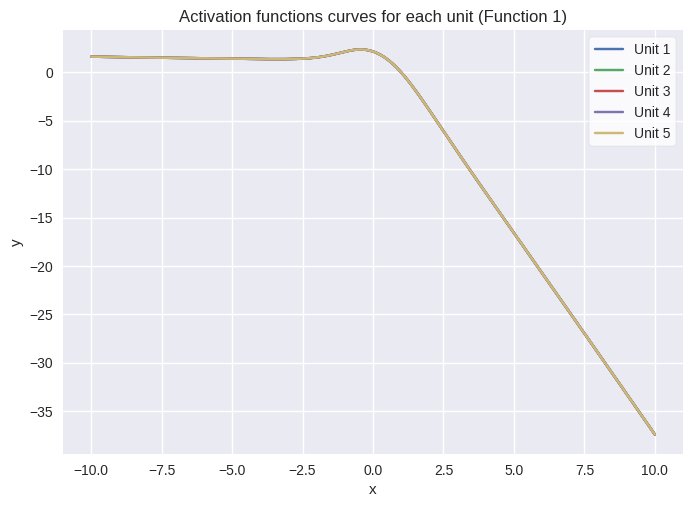

In [ ]:
###########################
# Examples for Function 1 #
###########################

n = 5 # amount of summed AFs
b = 3 # batch size
h = 5 # number of units

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
params, key = vmapped_init_fcn_1(subkey, n)

print("Examples for Function 1:")

# give in input a random matrix

key, subkey = jax.random.split(key)
x = jax.random.uniform(subkey, shape=(b, h), minval=-1, maxval=1)
y = vmapped_call_fcn_1(params, x)

print("\nOutput for random matrix in input (expected random values):")
print(y)

# give in input a batch with two equal samples

key, subkey = jax.random.split(key)
x = jax.random.uniform(subkey, shape=(1, h), minval=-1, maxval=1)
x = jnp.vstack([x] * 2)
y = vmapped_call_fcn_1(params, x)

print("\nOutput for equal samples matrix (expected rows equal one another):")
print(y)

# give in input a single sample with all equal values

key, subkey = jax.random.split(key)
x = jnp.ones(shape=(1, h))
y = vmapped_call_fcn_1(params, x)

print("\nOutput for equal units (expected equal values):")
print(y, "\n")

# plot the activation function curves of all the units

x = jnp.linspace(-10, 10, 1000).reshape(-1, 1)
x = jnp.hstack([x]*5)

y = vmapped_call_fcn_1(params, x)

for i in range(y.shape[1]):
    plt.plot(x[:, i], y[:, i], label=f'Unit {i+1}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Activation functions curves for each unit (Function 1)')
plt.legend(frameon=True, facecolor="white");

The expected plot for the second variant are **all different activation functions**.

To have a better understanding of the correct implementation I also decided to print the values of the activation functions for different inputs.
*   The first test input is a **random matrix**, simulating a batch of vectors. Similarly to before the expectation is for all the outputs to be different.
*   The second test input is a **matrix with equal rows**, simulating a batch with the same element repeated. As before the expectation is equal output rows.
*   The third test input is a **single vector where all the elements are equal**. Differently from before it is now expected for **all the values to be different, since each unit has its own activation function**.


Examples for Function 2:

Output for random matrix in input (expected random values):
[[-1.7458897   2.2911344  -0.04929687  1.9990945   2.0316126 ]
 [-1.1030111   2.7861276  -0.00491392  0.2751081   0.7642425 ]
 [-2.9880233   1.253036    0.09571631  1.7516453   0.3329636 ]]

Output for equal samples matrix (expected rows equal one another):
[[-0.433249    1.1968145   0.17247826  2.008904    2.0882566 ]
 [-0.433249    1.1968145   0.17247826  2.008904    2.0882566 ]]

Output for equal units (expected NOT equal values):
[[ 0.7044965   0.40017432 -0.11802515 -1.0117853   2.1899061 ]] 



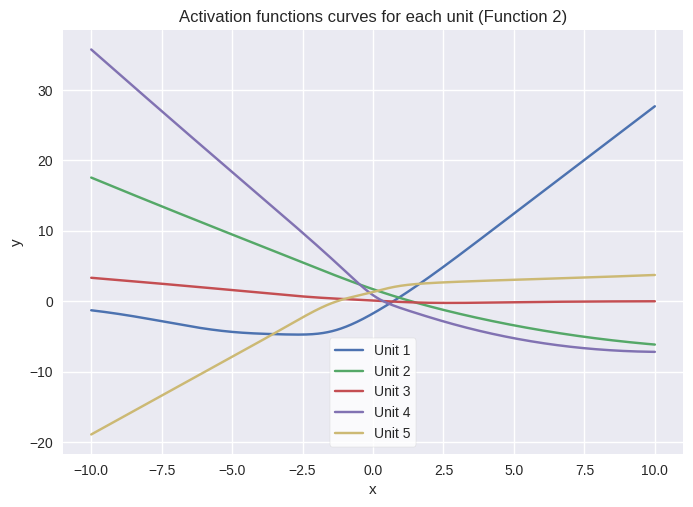

In [ ]:
###########################
# Examples for Function 2 #
###########################

n = 3 # amount of summed AFs
b = 3 # batch size
h = 5 # number of units

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
params, key = vmapped_init_fcn_2(subkey, n, h)

print("Examples for Function 2:")

# give as input a random matrix

key, subkey = jax.random.split(key)
x = jax.random.uniform(subkey, shape=(b, h), minval=-1, maxval=1)
y = vmapped_call_fcn_2(params, x)

print("\nOutput for random matrix in input (expected random values):")
print(y)

# give in input a batch with two equal samples

key, subkey = jax.random.split(key)
x = jax.random.uniform(subkey, shape=(1, h), minval=-1, maxval=1)
x = jnp.vstack([x] * 2)
y = vmapped_call_fcn_2(params, x)

print("\nOutput for equal samples matrix (expected rows equal one another):")
print(y)

# give in input a single sample with all equal values

key, subkey = jax.random.split(key)
x = jnp.ones(shape=(1, h))
y = vmapped_call_fcn_2(params, x)

print("\nOutput for equal units (expected NOT equal values):")
print(y, "\n")

# plot the activation function curves of all the units

x = jnp.linspace(-10, 10, 1000).reshape(-1, 1)
x = jnp.hstack([x]*5)

y = vmapped_call_fcn_2(params, x)

for i in range(y.shape[1]):
    plt.plot(x[:, i], y[:, i], label=f'Unit {i+1}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Activation functions curves for each unit (Function 2)')
plt.legend(frameon=True, facecolor="white");

The expected plot for the third variant are **all different activation functions**.

The call function behaves differently, following the "KAN-style" architecture: for each output unit we now have a vector of all the results of the application of the activation function for each input unit, which should be later merged inside the unit itself.

Beside the difference in the number of dimensions the test I have performed are the same and the expected results are analogous to those of the second variant.

Examples for Function 3:

Output for random matrix in input (expected random values):
[[[ 1.9468437  -0.40460077 -0.7246259 ]
  [-0.11963543 -0.70643055  0.32312882]
  [-0.6822775   0.33221468 -0.622003  ]]

 [[ 1.8947542  -0.63412684 -0.68445694]
  [-0.11505472 -0.26374617  0.25302607]
  [-0.6541659   0.24375837 -1.3922762 ]]

 [[ 1.1254128  -0.71098316 -0.6806085 ]
  [ 0.08711812 -0.13277397  0.24597982]
  [-0.27701682  0.2038455  -1.4671365 ]]]

Output for equal samples matrix (expected equal matrices):
[[[ 0.5781102  -0.31300595 -0.6996973 ]
  [ 0.4603726  -0.90733546  0.28037393]
  [-0.04071926  0.30984285 -1.0974783 ]]

 [[ 0.5781102  -0.31300595 -0.6996973 ]
  [ 0.4603726  -0.90733546  0.28037393]
  [-0.04071926  0.30984285 -1.0974783 ]]]

Output for equal units (expected NOT equal values):
[[[-0.01179571 -0.72677696 -0.67127573]
  [ 1.3863146  -0.10684477  0.22866161]
  [ 0.23870961  0.19599755 -1.6493094 ]]] 



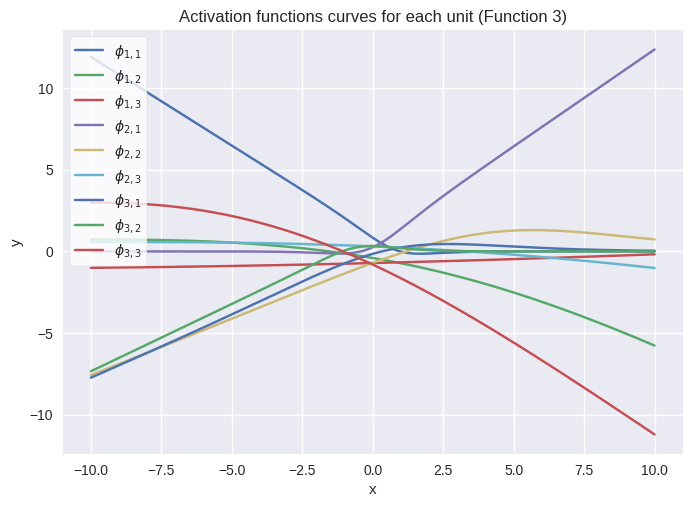

In [ ]:
###########################
# Examples for Function 3 #
###########################
n = 1 # amount of summed AFs
b = 3 # batch size
h1 = 3 # number of input units
h2 = 3 # number of output units

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
params, key = vmapped_init_fcn_3(subkey, n, h1, h2)

print("Examples for Function 3:")

# give as input a random matrix

key, subkey = jax.random.split(key)
x = jax.random.uniform(subkey, shape=(b, h1), minval=-1, maxval=1)
y = vmapped_call_fcn_3(params, x)

print("\nOutput for random matrix in input (expected random values):")
print(y)

# give in input a batch with two equal samples

key, subkey = jax.random.split(key)
x = jax.random.uniform(subkey, shape=(1, h1), minval=-1, maxval=1)
x = jnp.vstack([x] * 2)
y = vmapped_call_fcn_3(params, x)

print("\nOutput for equal samples matrix (expected equal matrices):")
print(y)

# give in input a single sample with all equal values

key, subkey = jax.random.split(key)
x = jnp.ones(shape=(1, h1))
y = vmapped_call_fcn_3(params, x)

print("\nOutput for equal units (expected NOT equal values):")
print(y, "\n")

# plot the activation function curves of all the units

x = jnp.linspace(-10, 10, 1000).reshape(-1, 1)
x = jnp.hstack([x] * h1)

y = vmapped_call_fcn_3(params, x)

for i in range(y.shape[1]):
    for j in range(y.shape[2]):
        plt.plot(x[:, 0], y[:, i, j], label='$\phi_{' + str(i+1) + ',' + str(j+1) + '}$')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Activation functions curves for each unit (Function 3)')
plt.legend(frameon=True, facecolor="white");

### Exercise 4 (2 point)

It is now time to train an MLP with our new activation functions. To begin with, select any **tabular dataset** that you like, for either classification or regression. A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/datasets).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. The choice of dataset will not influence the mark.

The objective of the exercise is to train an MLP with one hidden layer having as activation functions (1). In order to do this you have multiple choices:

1. You can do this completely in JAX by defining a new pair of (init, call) functions describing the complete model and performing gradient descent with these.
2. If you want to use Keras (note: `.fit` is *not allowed*) as in the second lab session, you need to port the trainable function in Keras. My suggestion is to subclass the `Layer` object by wrapping the functions you have already created (https://keras.io/guides/making_new_layers_and_models_via_subclassing/). The resulting layer will be backend-specific, which is not an issue. If you want something slightly harder, you can rewrite everything with Keras ops to make it backend-agnostic.
3. You can also use some high-level JAX library (e.g., Equinox, Haiku, ...). In this case, please document the code precisely.

✍ **DESCRIPTION OF THE DATASET**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

---

The dataset I decided to use is called **Steel Plates Faults**; I found it on the UC Irvine Machine Learning Repository at the following [link](https://archive.ics.uci.edu/dataset/198/steel+plates+faults). The dataset has been presented in 1998 with the Paper *MetaNet: The Theory of Independent Judges* by Dr. Massimo Buscema, researcher at Semeion Research Center of Sciences of Communication in Rome; the paper is available at the following [link](https://www.researchgate.net/publication/13731626_MetaNet_The_Theory_of_Independent_Judges).

The task of the dataset is a **multiclass classification of superficial defects on stainless steel plates** with 7 possible classes. The dataset contains 1941 instances with 27 features that according to the paper describe the geometric shape of the defect and its outline, but it is also said that since the work was commissioned by the *Centro Sviluppo Materiali* not many details can be given about those features. A noteworthy observation is that the target labels are already in a one-hot encoding format.

---

✅ **Completion requirement**: Show me the model trains as expected (e.g., loss, accuracy). It would be nice to visualize the functions before and after training.

---

Part of the code used in this exercise uses as base what has been done in the Lab 1 of the course and has been adapted for the different dataset and the custom activation function. Those adapted functions are $\text{accuracy()}$, $\text{cross_entropy()}$ and $\text{loss()}$.

In [ ]:
#############################
# TODO: complete Exercise 4 #
#############################

def prepare_data(batch_size: Int, test_size: Float = 0.2):
    '''
    The function downloads the Steel Plates Faults dataset from
    the UCI Machine Learning Repository and prepares the data for use.
    https://archive.ics.uci.edu/dataset/198/steel+plates+faults

    A regularization is performed on the features.
    The labels are already in a one-hot encoding format.
    '''

    # download the dataset
    plates = fetch_ucirepo(id=198)

    # get feaures and labels
    features = plates.data.features.values
    labels = plates.data.targets.values

    # split between train and test set
    x_train, x_test, y_train, y_test = train_test_split(features,
                                                        labels,
                                                        test_size=test_size,
                                                        random_state=42)

    # scale the data (fit only on train data)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # split into batches with TensorFlow
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(len(x_train)).batch(batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    test_dataset = test_dataset.batch(batch_size)

    # convert data types to those usable by JAX
    train_dataset = [(jnp.array(x), jnp.array(y)) for x, y in train_dataset]
    test_dataset = [(jnp.array(x), jnp.array(y)) for x, y in test_dataset]

    return train_dataset, test_dataset

def init_model(key: Int, n_features: Int, hidden_size: Int, n_classes: Int,\
               n: Int, relu_init: Bool = False, mean: Float = 0,\
               stdev: Float = 1):
    '''
    This function initialize all the parameters of the model and returns them
    as a tuple. The model is a Multi-Layer perceptron with one hidden layer
    that uses a different trainable custom activation function for each unit.

    Weights are initialized with a normal distribution and biases with zeros.
    In the same way the 'a' and 'c' parameters of the activation function are
    initialized with a normal distribution and 'b' and 'd' with zeros.
    '''

    # fully connected layer from input layer to hidden layer
    key, subkey = jax.random.split(key)
    weights_1 = jax.random.normal(subkey, shape=(n_features, hidden_size)) * stdev + mean
    biases_1 = jnp.zeros(shape=(hidden_size, ))

    # activation function
    key, subkey = jax.random.split(key)
    act_functs, _ = vmapped_init_fcn_2(subkey, n, hidden_size, relu_init, mean, stdev)

    # fully connected layer from hidden layer to output layer
    key, subkey = jax.random.split(key)
    weights_2 = jax.random.normal(subkey, shape=(hidden_size, n_classes)) * stdev + mean
    biases_2 = jnp.zeros(shape=(n_classes, ))

    return (weights_1, biases_1, act_functs, weights_2, biases_2)

@jax.jit
def call_model(params, x):
    '''
    This function implements the forward pass of the multi-layer perceptron.
    '''

    # from input layer to hidden layer
    z1 = jnp.dot(x, params[0]) + params[1]

    # activation function in the hidden layer
    a1 = vmapped_call_fcn_2(params[2], z1)

    # from the hidden layer to the output layer
    output_layer = jnp.dot(a1, params[3]) + params[4]

    return jax.nn.softmax(output_layer)

@jax.jit
def accuracy(y: Float[Array, "n 7"], y_pred: Float[Array, "n 7"]):
    return (y.argmax(axis=1) == y_pred.argmax(axis=1)).mean()

@jax.vmap
def cross_entropy(y: Float[Array, "classes"], y_pred: Float[Array, "classes"]) -> Float[Array, ""]:
    return -(y * jnp.log(y_pred)).sum()

@jax.jit
@jax.value_and_grad
def loss(params, x, y):
    return cross_entropy(y, call_model(params, x)).mean()

@jax.jit
def gradient_descent_step(params, grads, learning_rate):
    return tuple(params[i] - learning_rate * grads[i] for i in range(len(params)))

def train_model(params, train_dataset, epochs, learning_rate):
    '''
    Implements the training loop of the model. It also saves the history of
    loss and accuracy for plotting.
    '''

    loss_history = []
    accuracy_history = []

    for i in tqdm(range(epochs)):
        for batch in train_dataset:
            # get features and labels of batch
            x, y = batch

            # compute loss
            loss_value, grads = loss(params, x, y)

            # save values for plotting
            loss_history.append(loss_value)
            accuracy_history.append(accuracy(y, call_model(params, x)))

            # update parameters
            params = gradient_descent_step(params, grads, learning_rate)

        # learning rate decay every 100 epochs
        if i % 100 == 0:
            learning_rate *= 0.9

    return params, loss_history, accuracy_history

def plot_results(params, old_afs, loss_history, accuracy_history):
    '''
    This function plots the history of the loss of the model, its accuracy and
    the activation functions before and after the training.
    '''

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 5))

    ax1.plot(loss_history)
    ax1.set_title('Loss')

    ax2.plot(accuracy_history)
    ax2.set_title('Accuracy')

    x = jnp.linspace(-10, 10, 1000).reshape(-1, 1)
    x = jnp.hstack([x] * hidden_size)

    y = vmapped_call_fcn_2(old_afs, x)

    for i in range(y.shape[1]):
        ax3.plot(x[:, i], y[:, i], label=f'Unit {i+1}')

    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_title('Original activations')
    ax3.legend(frameon=True, facecolor="white")

    y = vmapped_call_fcn_2(params[2], x)

    for i in range(y.shape[1]):
        ax4.plot(x[:, i], y[:, i], label=f'Unit {i+1}')

    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    ax4.set_title('Trained activations')
    ax4.legend(frameon=True, facecolor="white")

def test_accuracy(params, test_dataset):
    '''
    Computes the accuracy of the model on a given dataset.
    '''

    accuracies = []
    for batch in test_dataset:
        x, y = batch
        accuracies.append(accuracy(y, call_model(params, x)))

    return float(sum(accuracies) / len(accuracies))

In [ ]:
# dataset parameters
n_features = 27
n_classes = 7
batch_size = 2000

# get data
train_dataset, test_dataset = prepare_data(batch_size)

In [ ]:
# model parameters
hidden_size = 10
n = 10
relu_init = True

# init model
key = jax.random.PRNGKey(0)
params = init_model(key, n_features, hidden_size, n_classes, n, relu_init, stdev=0.01)

# save initial activation functions
old_afs = params[2].copy()

  0%|          | 0/5000 [00:00<?, ?it/s]

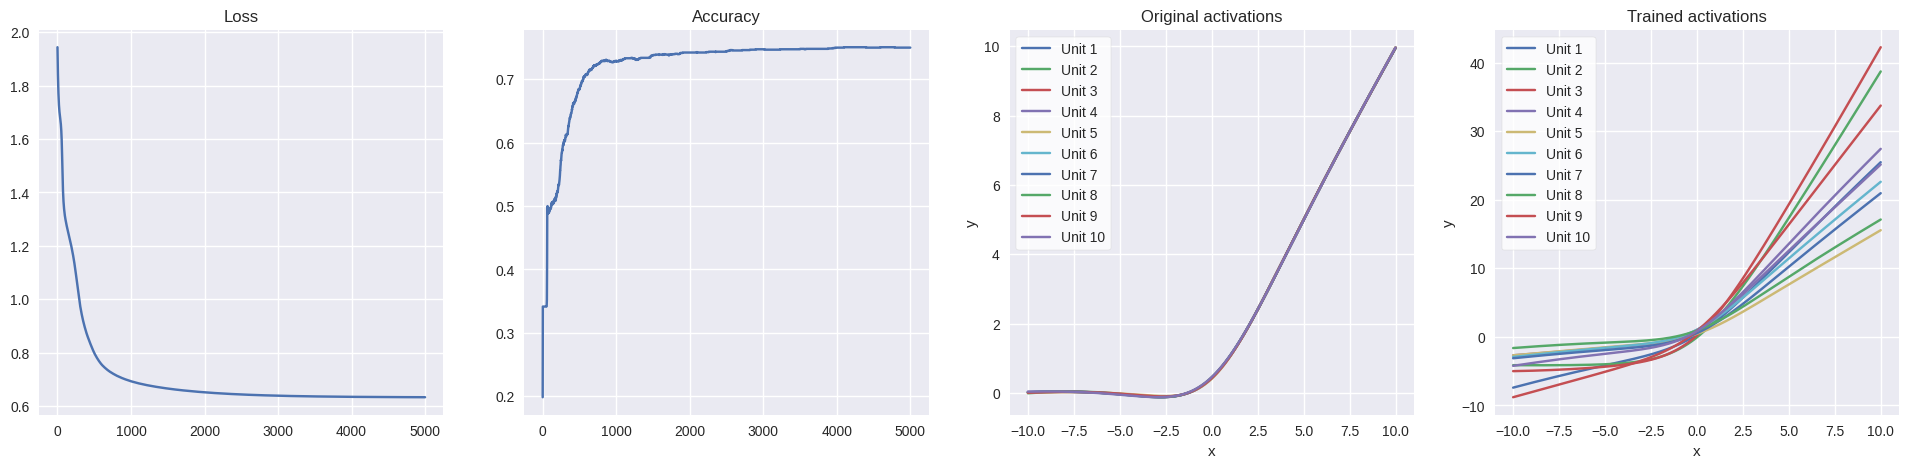

In [ ]:
# training parameters
epochs = 5000
learning_rate = 0.1

# execute training
params, loss_history, accu_history = train_model(params, train_dataset, epochs, learning_rate)

plot_results(params, old_afs, loss_history, accu_history)

In [ ]:
# measure accuracy

print(f"Train accuracy: {test_accuracy(params, train_dataset)}")
print(f"Test  accuracy: {test_accuracy(params, test_dataset)}")

Train accuracy: 0.75
Test  accuracy: 0.7506426572799683


The model seems to train correctly and the activation functions evolve during training. The shape of the activation functions after the training seem more resembling a *Leaky ReLU* and their magnitude is increased.

---

### Exercise 5 (optional, ungraded)

It could happen that the model does not work as expected because the parameters of the AF collapse to some "weird" behaviour. We can partially solve this by imposing a **regularization** term on the loss that penalizes deviations from the initialization.

For example, suppose that CE is the cross-entropy loss, and we initialize our AFs as the ReLU. If we have a single AF for simplicity, we can penalize deviations from the initialization as:

$$ \arg\min \sum_z \text{CE}(y_z, \hat{y}_z) + \lambda \sum_{i} (\phi(s_i) - \text{ReLU}(s_i))^2 \tag{2} $$

where $z$ loops over the training dataset, $\lambda\ge 0$ is a hyper-parameter that balances the strength of the regularization, and $s_i$ are a set of points sampled on the x-axis (the more points we sample, the stronger the regularization). This can be extended trivially to multiple AFs by summing over the different functions.

For this exercise, modify the training from Exercise 4 by including a term as in (2) (not necessarily the same, it is enough that it has a similar effect).


✅ **Completion requirement**: Show me regularization works as expected (e.g., compare the trained AFs to those from Exercise 4).

In [ ]:
#############################
# TODO: complete exercise 5 #
#############################

@jax.jit
@jax.value_and_grad
def regularized_loss(params, x, y, lam: Float = 0.1, n_samples: Int = 1000):
    '''
    Implementation of the loss described in formula (2).

    Since I have used a different activation function for each unit the
    regularization term is scaled by the amount of activation functions,
    otherwise the strenght of the regularization would increase with
    the amount of units.
    '''

    n_units = params[0].shape[1]

    ce_component = cross_entropy(y, call_model(params, x)).mean()

    x = jnp.linspace(-10, 10, n_samples).reshape(-1, 1)
    x = jnp.hstack([x] * params[0].shape[1])

    relu = real_relu(x)
    psi = vmapped_call_fcn_2(params[2], x)

    reg_component = jnp.sum((psi - relu) ** 2) / (n_samples * n_units)

    return ce_component + lam * reg_component

def train_model_regularized(params, train_dataset, epochs: Int,\
                            learning_rate: Float, lam: Float):
    '''
    The function implements the same training loop of Exercise 4 but with
    the regularization term. The only differences are the loss function and
    the addition of the regularization term as argument for the function.
    '''

    loss_history = []
    accuracy_history = []

    for i in tqdm(range(epochs)):
        for batch in train_dataset:
            # get features and labels of batch
            x, y = batch

            # compute loss
            loss_value, grads = regularized_loss(params, x, y, lam)

            # save values for plotting
            loss_history.append(loss_value)
            accuracy_history.append(accuracy(y, call_model(params, x)))

            # update parameters
            params = gradient_descent_step(params, grads, learning_rate)

        # learning rate decay
        if i % 100 == 0:
            learning_rate = learning_rate * 0.9

    return params, loss_history, accuracy_history

In [ ]:
# model parameters
hidden_size = 10
n = 10
relu_init = True

# init model
key = jax.random.PRNGKey(0)
params = init_model(key, n_features, hidden_size, n_classes, n, relu_init, stdev=0.01)

# save initial activation functions
old_afs = params[2].copy()

  0%|          | 0/5000 [00:00<?, ?it/s]

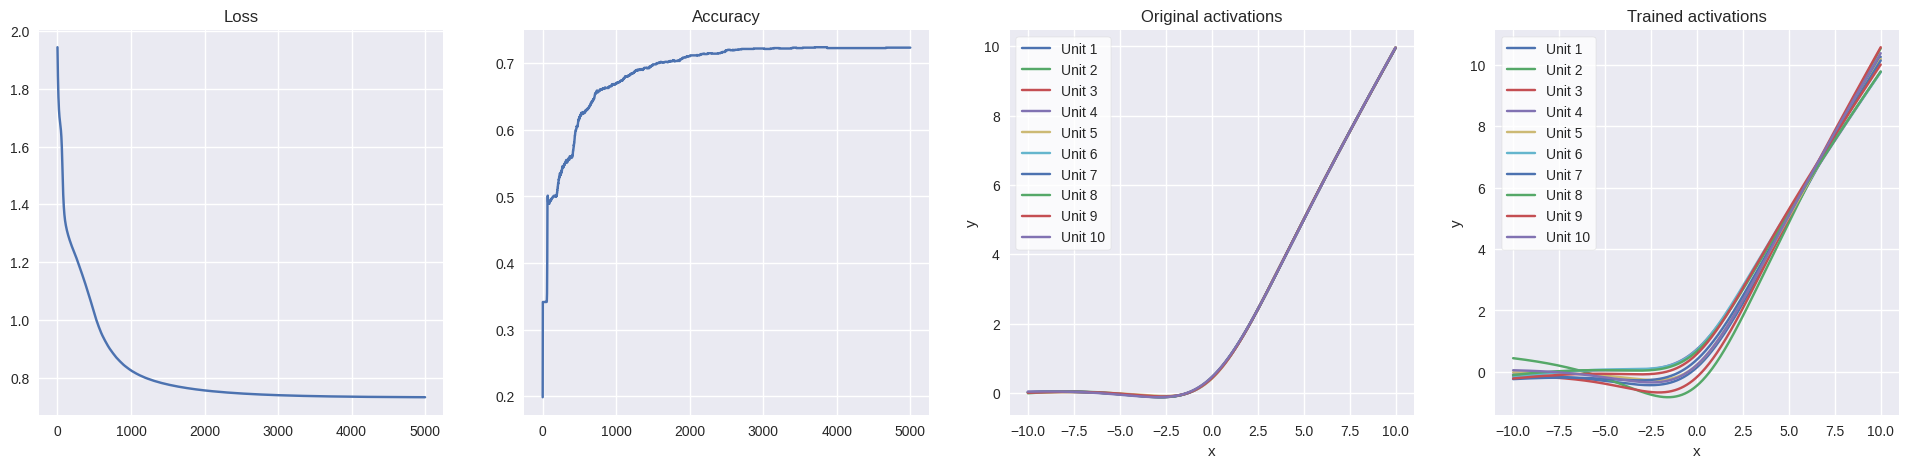

In [ ]:
# training parameters
epochs = 5000
learning_rate = 0.1
lam = 0.1

# execute training
params, loss_history, acc_history = train_model_regularized(params, train_dataset, epochs, learning_rate, lam)

plot_results(params, old_afs, loss_history, acc_history)

In [ ]:
# measure accuracy

print(f"Train accuracy: {test_accuracy(params, train_dataset)}")
print(f"Test  accuracy: {test_accuracy(params, test_dataset)}")

Train accuracy: 0.7235824465751648
Test  accuracy: 0.7249357104301453


As expected when introducing regularization the activation functions maintain more the magnitude and the shape of the ReLU.

As a final experiment we also see what happens without the ReLU initialization in both the cases with and without the introduction of regularization:

  0%|          | 0/5000 [00:00<?, ?it/s]

Train accuracy: 0.75
Test  accuracy: 0.7326478362083435


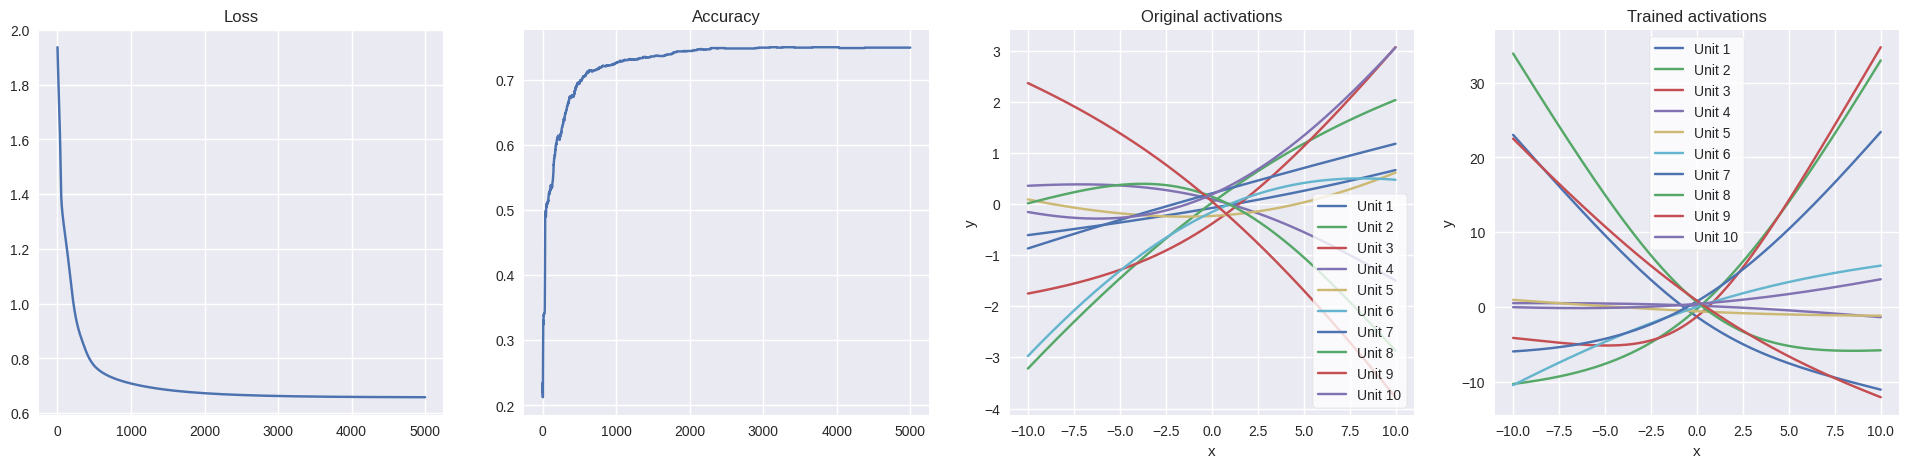

In [ ]:
###################################
# No ReLU init, no regularization #
###################################

# model parameters
hidden_size = 10
n = 10
relu_init = False

# init model
key = jax.random.PRNGKey(0)
params = init_model(key, n_features, hidden_size, n_classes, n, relu_init, stdev=0.1)

# save initial activation functions
old_afs = params[2].copy()

# training parameters
epochs = 5000
learning_rate = 0.1

# execute training
params, loss_history, acc_history = train_model(params, train_dataset, epochs, learning_rate)

plot_results(params, old_afs, loss_history, acc_history)

# measure accuracy

print(f"Train accuracy: {test_accuracy(params, train_dataset)}")
print(f"Test  accuracy: {test_accuracy(params, test_dataset)}")

  0%|          | 0/5000 [00:00<?, ?it/s]

Train accuracy: 0.737113356590271
Test  accuracy: 0.7275063991546631


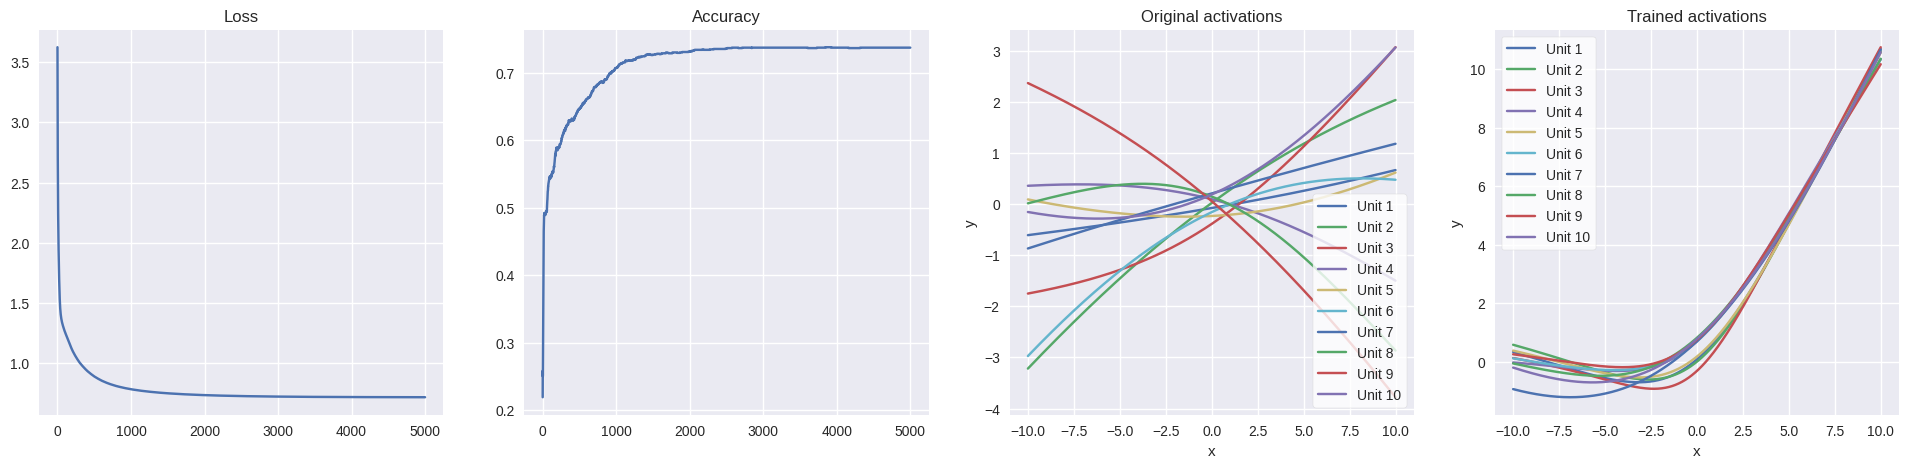

In [ ]:
#####################################
# No ReLU init, with regularization #
#####################################

# model parameters
hidden_size = 10
n = 10
relu_init = False

# init model
key = jax.random.PRNGKey(0)
params = init_model(key, n_features, hidden_size, n_classes, n, relu_init, stdev=0.1)

# save initial activation functions
old_afs = params[2].copy()

# training parameters
epochs = 5000
learning_rate = 0.1
lam = 0.1

# execute training
params, loss_history, acc_history = train_model_regularized(params, train_dataset, epochs, learning_rate, lam)

plot_results(params, old_afs, loss_history, acc_history)

# measure accuracy

print(f"Train accuracy: {test_accuracy(params, train_dataset)}")
print(f"Test  accuracy: {test_accuracy(params, test_dataset)}")

The overall behavior seems to indicate that using the **initialization of the activation funtion that mimicks a ReLU decreases the overfitting** leading to overall better performances.

The model with ReLU initialization and without regularization maintain activation functions of similar shape, while the model with random initialization uses vary different activation functions, some of which even very close to straight lines.

Moreover the model with regularization and random initialization seem able to learn ReLU from just the "push" given by the regularization.

---

### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 13/11/2024 23:59** on the Google Classrom page.

### References

[1] Apicella, A., Donnarumma, F., Isgrò, F. and Prevete, R., 2021. A survey on modern trainable activation functions. Neural Networks, 138, pp. 14-32.

[2] Liu, Z., Wang, Y., Vaidya, S., Ruehle, F., Halverson, J., Soljačić, M., Hou, T.Y. and Tegmark, M., 2024. KAN: Kolmogorov-Arnold networks. arXiv preprint arXiv:2404.19756.